In [1]:
import os
import subprocess

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from tqdm.auto import tqdm

from radmc3dPy.image import readImage, plotImage, makeImage
from astropy import constants as c

au = c.au.cgs.value
pc = c.pc.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value
Grav = c.G.cgs.value
m_p = c.m_p.cgs.value


def logistic(a, r, r0, dr):
    return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


def grid_refine_inner_edge(x_orig, nlev, nspan):
    x = x_orig.copy()
    rev = x[0] > x[1]
    for ilev in range(nlev):
        x_new = 0.5 * (x[1:nspan + 1] + x[:nspan])
        x_ref = np.hstack((x, x_new))
        x_ref.sort()
        x = x_ref
        if rev:
            x = x[::-1]
    return x


def warp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(theta) - y * np.sin(theta) * np.cos(phi) + z * np.sin(theta) * np.sin(phi)
    yprime = x * np.sin(theta) + y * np.cos(theta) * np.cos(phi) - z * np.sin(phi) * np.cos(theta)
    zprime = y * np.sin(phi) + z * np.cos(phi)
    return xprime, yprime, zprime


def unwarp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(theta) + y * np.sin(theta)
    yprime = -x * np.sin(theta) * np.cos(phi) + y * np.cos(theta) * np.cos(phi) + z * np.sin(phi)
    zprime = x * np.sin(theta) * np.sin(phi) - y * np.sin(phi) * np.cos(theta) + z * np.cos(phi)
    return xprime, yprime, zprime

# Velocity transformations

def vel_sph_to_car(THETAU, PHIU, VRU, VTU, VPU):
    
    vx = VRU * np.sin(THETAU) * np.cos(PHIU) + VTU * np.cos(THETAU) * np.cos(PHIU) - VPU * np.sin(PHIU)
    vy = VRU * np.sin(THETAU) * np.sin(PHIU) + VTU * np.cos(THETAU) * np.sin(PHIU) + VPU * np.cos(PHIU)
    vz = VRU * np.cos(THETAU)                - VTU * np.sin(THETAU)
    
    return vx, vy, vz

def vel_car_to_sph(THETAC, PHIC, VXW, VYW, VZW):
    
    vr =  VXW * np.sin(THETAC) * np.cos(PHIC) + VYW * np.sin(THETAC) * np.sin(PHIC) + VZW * np.cos(THETAC)
    vt =  VXW * np.cos(THETAC) * np.cos(PHIC) + VYW * np.cos(THETAC) * np.sin(PHIC) - VZW * np.sin(THETAC)
    vp = -VXW * np.sin(PHIC)                  + VYW * np.cos(PHIC)
    
    return vr, vt, vp

def vel_car_to_sph_TIL(THETAC, PHIC, VXW, VYW, VZW):
    VRW =  VXW * np.sin(THETAC) * np.cos(PHIC) + VYW * np.sin(THETAC) * np.sin(PHIC) + VZW * np.cos(THETAC)
    VTW = -VXW * np.sin(THETAC) * np.sin(PHIC) + VYW * np.sin(THETAC) * np.cos(PHIC)
    VPW =  VXW * np.cos(THETAC) * np.cos(PHIC) + VYW * np.cos(THETAC) * np.sin(PHIC) - VZW * np.sin(THETAC)
    return VRW, VTW, VPW

def vel_sph_to_car_TIL(THETAU, PHIU, VRU, VTU, VPU):
    VXU = VRU * np.sin(THETAU) * np.cos(PHIU) + VTU * np.cos(THETAU) * np.cos(PHIU) - VPU * np.sin(THETAU) * np.sin(PHIU)
    VYU = VRU * np.sin(THETAU) * np.sin(PHIU) + VTU * np.cos(THETAU) * np.sin(PHIU) + VPU * np.sin(THETAU) * np.cos(PHIU)
    VZU = VRU * np.cos(THETAU)                - VTU * np.sin(THETAU)
    return VXU, VYU, VZU
    
def vel_car_to_sph_2(x, y, z, vx, vy, vz):
    # Velocities
    rho = x**2 + y**2
    r = x**2 + y**2 + z**2 
    
    vr = (x*vx + y*vy + z*vz)/np.sqrt(r)
    vtheta = (-(x*vx + y*vy)*z + (rho)*vz)/(np.sqrt(rho)*(r))
    vphi = (x*vy - y*vx)/(rho)
    return vr, vtheta, vphi

In [2]:
def call_radmc(cmd, verbose=False, total=None):
    """
    Run radmc3d command and show progress bar instead.
    
    cmd : str
        the command to run, e.g. 'radmc3d mctherm'
        
    verbose : bool
        if True, then all output except the photon packges are shown
        if False, just the progress is shown.
        
    total : None | int
        total number of photon packages, if known
    """
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, text=True)
    output = []
    
    if 'nphot' in cmd:
        total = int(cmd.split('nphot')[1].split()[1])

    with tqdm(total=total, unit='photons') as pbar:
        for line in p.stdout:
            if 'Photon nr' in line:
                pbar.update(1000)
            elif verbose:
                print(line, end='')
            output += [line]
    rc = p.wait()
    return rc, ''.join(output)

In [3]:
# Monte Carlo parameters
#
nphot_therm = 1000000
nphot_scat  = 1000000

#### Increase the number of points in theta so we obtain cells closer to the midplane (theta=pi/2)

In [4]:
# Grid parameters
#
n_r     = 75
n_theta = 256 # Increase 
n_phi   = 32
r_in    = 0.5 * au
r_out   = 35 * au
thetaup = 0.       # Theta grid starting point (0=pole, but singular, so choose >0)

In [5]:
# inner edge grid refinement
nlev_rin  = 8
nspan_rin = 3

In [6]:
# Disk parameters
#
sigma_0   = 1e1         # Gas surface density at 1 au [g / cm^2]
d2g       = 0.01        # dust-to-gas ratio
gamma_gas = 1.0         # power-law exponent of the surface density
hor_0     = 0.05        # h/r at 1 au
hor_exp   = 0.1         # flaring exponent

In [7]:
# Star parameters
#
M_star = 2.4 * M_sun
R_star = 2.4 * R_sun
T_star = 1e4
star_coord = np.array([0., 0., 0.])

In [8]:
# Make the coordinates
#
ri     = np.geomspace(r_in, r_out, n_r + 1)
#ri     = grid_refine_inner_edge(ri, nlev_rin, nspan_rin)   # Refinement at inner edge
thetai = np.linspace(thetaup, np.pi - thetaup, n_theta + 1)
phii   = np.linspace(0.0, 2.0 * np.pi, n_phi + 1)
rc     = 0.5 * (ri[:-1] + ri[1:])
thetac = 0.5 * (thetai[:-1] + thetai[1:])
phic   = 0.5 * (phii[:-1] + phii[1:])
n_r    = len(rc)     # Recompute nr, because of refinement at inner edge

In [9]:
# Make the full mesh
#
print(thetac[n_theta//2])
print(np.pi/2)

RC, THETAC, PHIC = np.meshgrid(rc, thetac, phic, indexing='ij')
XC = RC * np.sin(THETAC) * np.cos(PHIC)
YC = RC * np.sin(THETAC) * np.sin(PHIC)
ZC = RC * np.cos(THETAC)

# Midplane index
RCMP = RC[:, n_theta//2, :]
THETAMP = THETAC[:, n_theta//2, :]
PHIMP = PHIC[:, n_theta//2, :]

print(RCMP.max())


XMP = XC[:, n_theta//2+1, :]
YMP = YC[:, n_theta//2+1, :]
ZMP = ZC[:, n_theta//2+1, :]

1.576932249946439
1.5707963267948966
509174888626376.8


## Make the warped model

In [10]:
# un-warp the coordinates
#
warp = 45.   #
twist = 0. # 
dr = 0
r0 = 20

warp_array  = logistic(warp , rc, r0 * au, dr * au)  # Specify the r0 and dr in AU
twist_array = logistic(twist, rc, r0 * au, dr * au)

/tmp/ipykernel_129118/2037438888.py:24: RuntimeWarning: divide by zero encountered in true_divide
  return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


In [11]:
def vel_field(rc, thetac, phic, n_theta, warp, twist, r0, dr):
    """
    This function recieves the coordinate centers, and gets the disk mid
    plane, then it warps the velocities and positions to visualize 
    them in the warped geometry. 
    """
    
    RC, PHIC = np.meshgrid(rc, phic, indexing='ij')
    THETAC   = np.zeros_like(RC)
        
    XC = RC * np.cos(PHIC)
    YC = RC * np.sin(PHIC)
    ZC = np.zeros_like(YC)
    
    # Create the warp arrays
    warp_array  = logistic(warp , rc, r0 * au, dr * au)  # Specify the r0 and dr in AU
    twist_array = logistic(twist, rc, r0 * au, dr * au)
    
    
    # Warp the coordinates
    XU, YU, ZU = unwarp_coordinates(XC, YC, ZC,
                                    warp_array[:, None],
                                    twist_array[:, None])
    
    # Create the velocity array
    VR     = np.zeros_like(RC)
    VTHETA = np.zeros_like(RC)
    VPHI   = np.sqrt(Grav * M_sun / RC)
    #VPHI = np.ones_like(RCMP)
    
    # Transform to cartesian and warp the velocities
    VXC, VYC, VZC = vel_sph_to_car(THETAC, PHIC, VR, VTHETA, VPHI)

    VXU, VYU, VZU = unwarp_coordinates(
        VXC, VYC, VZC,
        warp_array[:, None],
        twist_array[:, None])
    
    return XU/au, YU/au, ZU/au, VXU, VYU, VZU

In [12]:
xu, yu, zu, vxu, vyu, vzu = vel_field(rc=rc,
                                      thetac=thetac,
                                      phic=phic,
                                      n_theta=n_theta,
                                      warp=warp,
                                      twist=twist,
                                      r0=r0,
                                      dr=dr)

vxu[vxu==vxu[0,0]] = np.nan
vyu[vyu==vyu[0,0]] = np.nan
vzu[vzu==vzu[0,0]] = np.nan

/tmp/ipykernel_129118/2037438888.py:24: RuntimeWarning: divide by zero encountered in true_divide
  return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


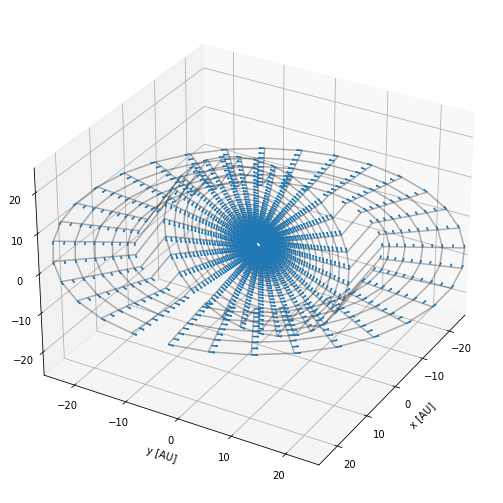

In [13]:
f = plt.figure(figsize=(14,9))
ax = f.add_subplot(projection='3d')
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_zlim(-25, 25)

ax.quiver(xu, yu, zu, vxu, vyu, vzu, normalize=True)
ax.plot_wireframe(xu, yu, zu, alpha=0.3, color='black')
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")


elev = 60
azim = 30
ax.view_init(90 - elev, azim)